<a href="https://colab.research.google.com/github/sgr1118/Kaggle-Transcription/blob/main/%5BFlib01%5DSentiment_Analysis_on_Movie_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
:# 구글 API 불러오기3
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rlfkr1234","key":"cf174d7e08b9e8738f8815cd6a5ad980"}'}

In [ ]:
!ls -1ha kaggle.json
# kaggle json 파일 업로드 확인

kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c sentiment-analysis-on-movie-reviews

  0% 0.00/1.90M [00:00<?, ?B/s]
100% 1.90M/1.90M [00:00<00:00, 167MB/s]


In [ ]:
!ls

kaggle.json  sample_data  sentiment-analysis-on-movie-reviews.zip


In [ ]:
# 불러온 파일이 알집인 경우 
!unzip /content/sentiment-analysis-on-movie-reviews.zip

Archive:  /content/sentiment-analysis-on-movie-reviews.zip
  inflating: sampleSubmission.csv    
  inflating: test.tsv.zip            
  inflating: train.tsv.zip           


In [ ]:
!unzip /content/train.tsv.zip

Archive:  /content/train.tsv.zip
  inflating: train.tsv               


In [ ]:
!unzip /content/test.tsv.zip

Archive:  /content/test.tsv.zip
  inflating: test.tsv                


# Import required libraries

In [ ]:
# 라이브러리 불러오기

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk import ngrams
import string, re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import warnings,os

In [ ]:
plt.figure(figsize=(16,7))
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

<Figure size 1152x504 with 0 Axes>

Load data

In [ ]:
train = pd.read_csv('/content/train.tsv', sep = '\t')
test = pd.read_csv('/content/test.tsv', sep = '\t')

print(train.shape, test.shape)

(156060, 4) (66292, 3)


# Part 1 EDA

In [ ]:
# 데이터 확인
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


PhraseId : 구절의 id

SentenceId : 문장의 id

Phrase : 리뷰 내용

Sentiment : 리뷰의 긍부정

Sentiment의 label

0 - negative, 
1 - somewhat negative, 
2 - neutral,
3 - somewhat positive,
4 - positive,



In [ ]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [ ]:
# 데이터 형태 확인

train.info()

# Phrase를 제외한 다른 columns는 정수형

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [ ]:
# 결측치 확인

train.isnull().sum()

# 결측치 존재하지 않음.

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

Sentiment Description

In [ ]:
train['sentiment_class'] = train['Sentiment'].map({0:'negative',1:'somewhat negative',2:'neutral',3:'somewhat positive',4:'positive'})

train.head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class
0,1,1,A series of escapades demonstrating the adage ...,1,somewhat negative
1,2,1,A series of escapades demonstrating the adage ...,2,neutral
2,3,1,A series,2,neutral
3,4,1,A,2,neutral
4,5,1,series,2,neutral


Remove punctuations (구두점 제거)

In [ ]:
def remove_punctuation(text):
  return ''.join([t for t in text if t not in string.punctuation])

In [ ]:
train['Phrase'] = train['Phrase'].apply(lambda x:remove_punctuation(x))
train.sample(10)

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class
100869,100870,5298,Lang,2,neutral
147971,147972,8053,and creepy atmosphere,2,neutral
9345,9346,390,The town has kind of an authentic feel but,3,somewhat positive
8400,8401,349,a firsttime actor RRB,2,neutral
45766,45767,2225,was nt just bad,0,negative
54919,54920,2734,refugees,2,neutral
87609,87610,4549,at the French Revolution,2,neutral
82826,82827,4277,is too much like a fragment of an underdone po...,1,somewhat negative
139878,139879,7589,extended by Iran,2,neutral
13934,13935,600,middle passages,2,neutral


Remove words with less than 2 characters (문자 길이가 2이하인 데이터 제거)

In [ ]:
def words_with_more_than_three_chars(text):
  return ' '.join([t for t in text.split() if len(t) > 3])

In [ ]:
train['Phrase']=train['Phrase'].apply(lambda x:words_with_more_than_three_chars(x))
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class
0,1,1,series escapades demonstrating adage that what...,1,somewhat negative
1,2,1,series escapades demonstrating adage that what...,2,neutral
2,3,1,series,2,neutral
3,4,1,,2,neutral
4,5,1,series,2,neutral


Remove stopwords (불용구 제거)

In [ ]:
# stopwords download
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = stopwords.words('english')

train['Phrase'] = train['Phrase'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class
0,1,1,series escapades demonstrating adage good goos...,1,somewhat negative
1,2,1,series escapades demonstrating adage good goose,2,neutral
2,3,1,series,2,neutral
3,4,1,,2,neutral
4,5,1,series,2,neutral


In [ ]:
# 결과 확인

train.iloc[8400]

# a라는 관사가 지워진걸 확인

PhraseId                      8401
SentenceId                     349
Phrase             firsttime actor
Sentiment                        2
sentiment_class            neutral
Name: 8400, dtype: object

check sentiment categories (감정 카테고리 확인)

In [ ]:
train.groupby('Sentiment')['Sentiment'].count()

Sentiment
0     7072
1    27273
2    79582
3    32927
4     9206
Name: Sentiment, dtype: int64

Visualize the target variables (타겟 변수 시각화)

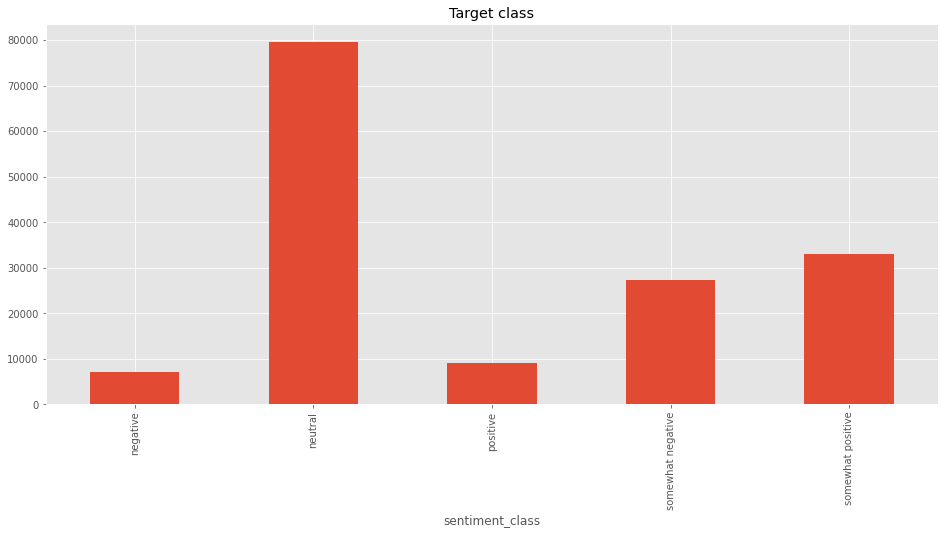

In [ ]:
train.groupby('sentiment_class')['sentiment_class'].count().plot(kind='bar',
                                                                 title = 'Target class',
                                                                 figsize = (16,7), fontsize = 10, grid = True)

Get percentages of each class (각 클래스의 비율)

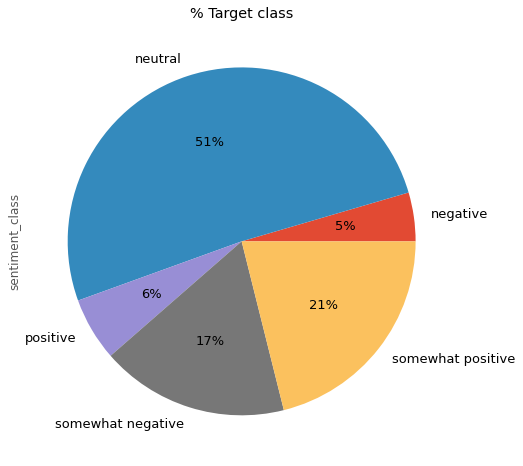

In [ ]:
((train.groupby('sentiment_class')['sentiment_class'].count()/train.shape[0])*100).plot(
    kind='pie', figsize=(8,8), fontsize = 13, title = '% Target class', autopct='%1.0f%%')

Adding Phrase length (문자열 길이 column 추가)

In [ ]:
train['PhraseLength'] = train['Phrase'].apply(lambda x: len(x))

In [ ]:
train.sort_values(by = 'PhraseLength', ascending = False).head()
# 내림차순으로 상위 5개 출력

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class,PhraseLength
54876,54877,2734,Filmmakers Dana JanklowiczMann Amir Mann area ...,3,somewhat positive,207
62992,62993,3189,addition sporting worst titles recent cinemati...,0,negative,200
26148,26149,1199,movie biggest shocks come seeing former nymphe...,1,somewhat negative,199
62500,62501,3162,While transgressive trappings especially frank...,1,somewhat negative,197
72577,72578,3708,Stephen Earnhart documentary decomposition hea...,1,somewhat negative,196


Distribution of phrase length on each class
(각 클래스의 문장길이 분포 확인)

[seaborn 누적 분포 그래프](https://seaborn.pydata.org/tutorial/distributions.html)

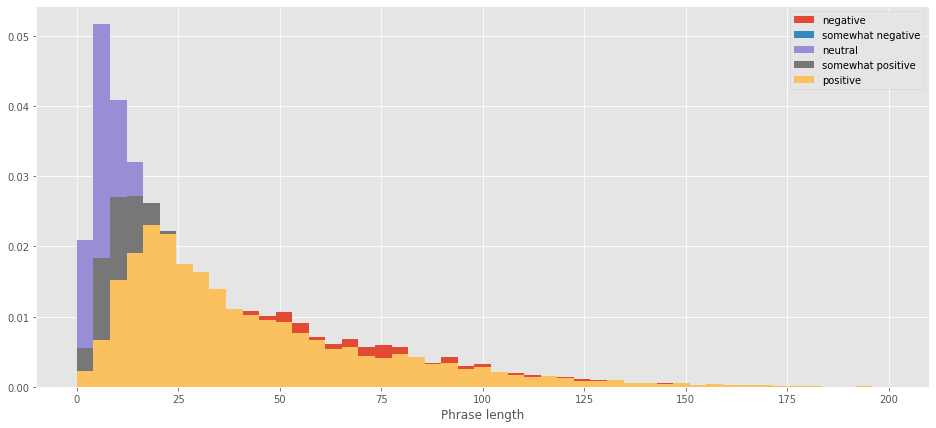

In [ ]:
plt.figure(figsize=(16,7))

bins = np.linspace(0, 200, 50)
plt.hist(train[train['sentiment_class']=='negative']['PhraseLength'], bins=bins, density=True,label='negative')
plt.hist(train[train['sentiment_class']=='somewhat negative']['PhraseLength'], bins=bins, density=True,label='somewhat negative')
plt.hist(train[train['sentiment_class']=='neutral']['PhraseLength'], bins=bins, density=True,label='neutral')
plt.hist(train[train['sentiment_class']=='somewhat positive']['PhraseLength'], bins=bins, density=True,label='somewhat positive')
plt.hist(train[train['sentiment_class']=='positive']['PhraseLength'], bins=bins, density=True,label='positive')
plt.xlabel('Phrase length')
plt.legend()
plt.show()

Common words with word cloud (워드클라우드 만들기)

[iterrows 설명](https://cosmosproject.tistory.com/368)

In [ ]:
from wordcloud import WordCloud, STOPWORDS 
stopwords = set(STOPWORDS)

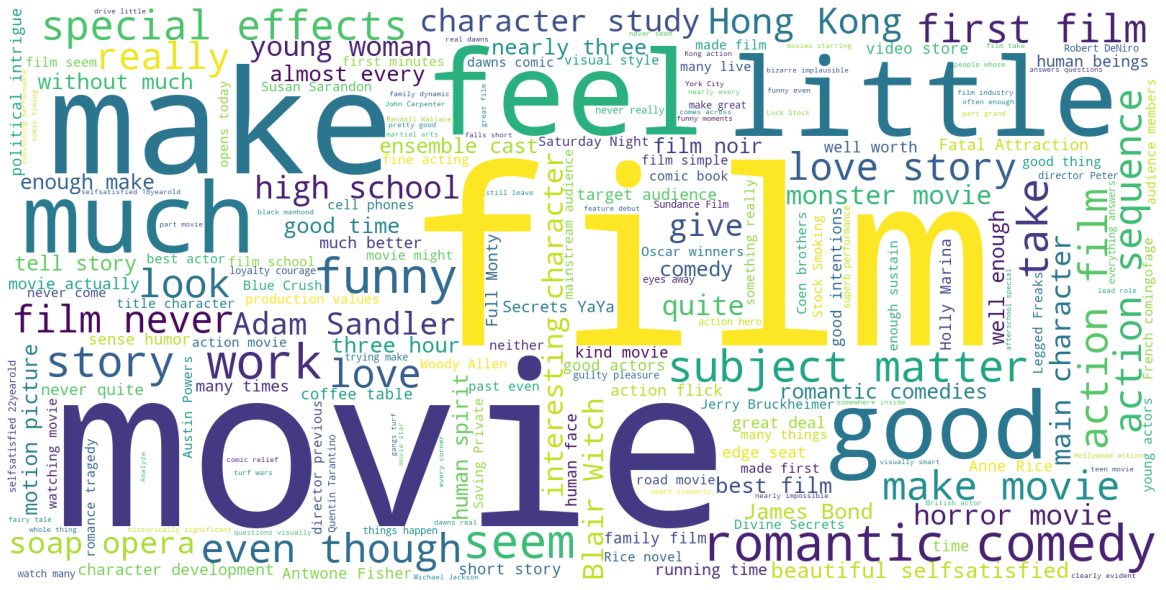

In [ ]:
import wordcloud
word_cloud_common_words = []
for index, row in train.iterrows():
  word_cloud_common_words.append((row['Phrase']))
word_cloud_common_words

wordcloud = WordCloud(width = 1600, height = 800, background_color = 'white', stopwords = stopwords,
                      min_font_size = 5).generate(''.join(word_cloud_common_words))

# 워드 클라우드 이미지 그리기
plt.figure(figsize = (16, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

Word Frequency (단어 빈도)

LookupError: Resource punkt not found.
  Please use the NLTK Downloader to obtain the resource:

해결법 : nltk.download('punkt') 입력 

In [ ]:
nltk.download('punkt') 

text_list=[]  
for index, row in train.iterrows(): 
  text_list.append((row['Phrase'])) 
text_list

total_words=''.join(text_list)
total_words=word_tokenize(total_words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
freq_words = FreqDist(total_words)
word_frequency = FreqDist(freq_words)

In [ ]:
# 상위 10개 빈도를 차지하는 단어 추출
print(word_frequency.most_common(10))

[('film', 3259), ('movie', 2892), ('like', 1968), ('story', 1204), ('much', 1085), ('good', 1069), ('even', 1041), ('characters', 994), ('little', 976), ('make', 838)]


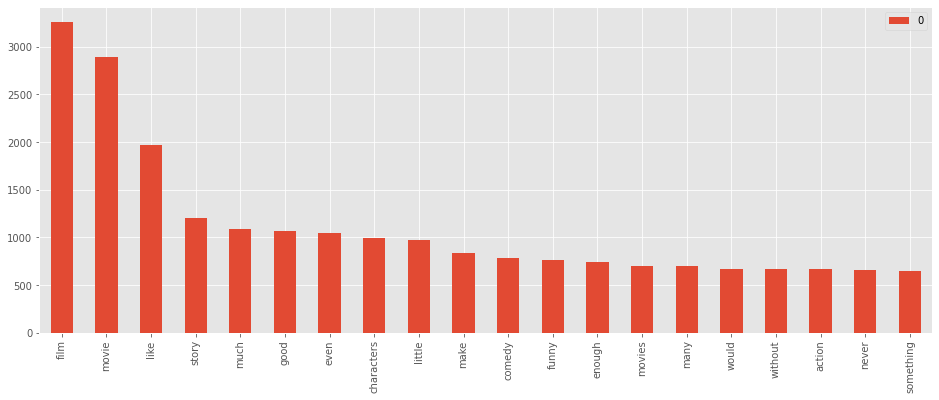

In [ ]:
# 시각화
pd.DataFrame(word_frequency, index=[0]).T.sort_values(by = [0], ascending = False).head(20).plot(
    kind = 'bar', figsize = (16,6), fontsize = 10, grid = True)

Common words used for negative sentiment (부정 리뷰에서 많이 사용되는 단어)

In [ ]:
neg_text_list = []

for index, row in train[train['Sentiment'] == 0].iterrows():
  neg_text_list.append((row['Phrase']))
neg_text_list

neg_total_words = ' '.join(neg_text_list)
neg_total_words = word_tokenize(neg_total_words)

neg_freq_words = FreqDist(neg_total_words)
neg_word_frequency = FreqDist(neg_freq_words)

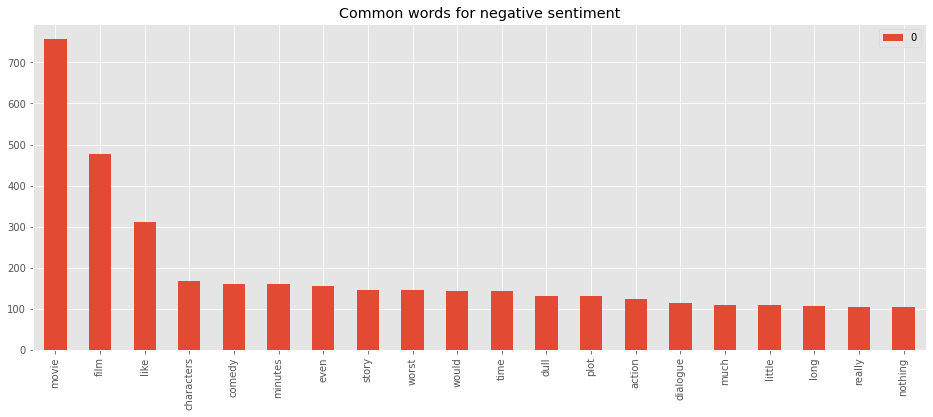

In [ ]:
# 시각화
pd.DataFrame(neg_word_frequency, index = [0]).T.sort_values(by = [0], ascending = False).head(20).plot(
    kind = 'bar', figsize = (16,6), fontsize = 10, grid = True, title = 'Common words for negative sentiment')

Common words used for positive sentiment (긍정 리뷰에서 많이 사용되는 단어)

In [ ]:
pos_text_list = []

for index, row in train[train['Sentiment'] == 4].iterrows():
  pos_text_list.append((row['Phrase']))
pos_text_list

pos_total_words = ' '.join(pos_text_list)
pos_total_words = word_tokenize(pos_total_words)

pos_freq_words = FreqDist(pos_total_words)
pos_word_frequency = FreqDist(pos_freq_words)

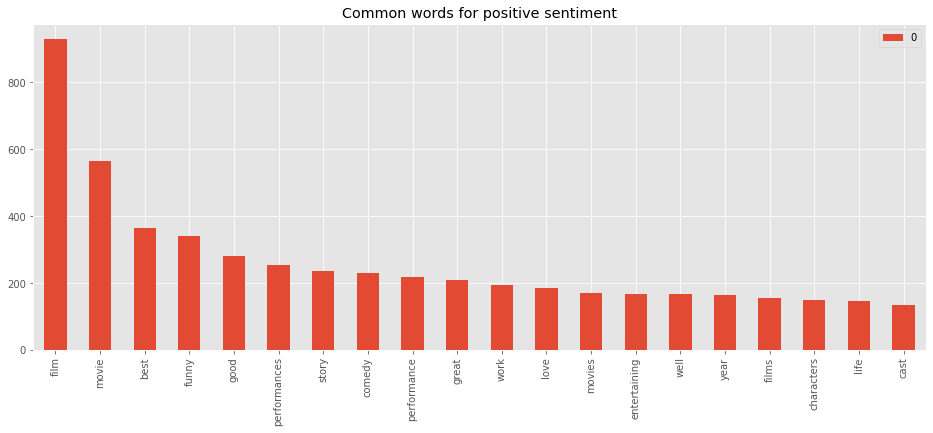

In [ ]:
# 시각화
pd.DataFrame(pos_word_frequency, index = [0]).T.sort_values(by = [0], ascending = False).head(20).plot(
    kind = 'bar', figsize = (16,6), fontsize = 10, grid = True, title = 'Common words for positive sentiment')

Common bigram words used for positive sentiment
(긍정 리뷰에서 많이 사용되어 2 단어 짝)

[bigram 위키독스 설명](https://wikidocs.net/21692)
[N-gram language model 설명](https://jiho-ml.com/weekly-nlp-14/)


In [ ]:
text = 'Tom and Jerry love mickey. But mickey dont love Tom and Jerry. What a love mickey is getting from these two friends'

bigram_frequency = FreqDist(ngrams(word_tokenize(text),3))
bigram_frequency.most_common()[0:5]

# 1문장 안에 'Tom', 'and', 'Jerry'가 연속적으로 나온 경우가 2번인것을 알 수 있다.

[(('Tom', 'and', 'Jerry'), 2),
 (('and', 'Jerry', 'love'), 1),
 (('Jerry', 'love', 'mickey'), 1),
 (('love', 'mickey', '.'), 1),
 (('mickey', '.', 'But'), 1)]

In [ ]:
text_list = []

for index, row in train.iterrows():
  text_list.append((row['Phrase']))
text_list

total_words = ' '.join(text_list)
total_words = word_tokenize(total_words)

freq_words = FreqDist(total_words)
word_frequency = FreqDist(ngrams(freq_words, 2))
word_frequency.most_common()[0:5]

[(('film', 'movie'), 1),
 (('movie', 'like'), 1),
 (('like', 'story'), 1),
 (('story', 'good'), 1),
 (('good', 'characters'), 1)]

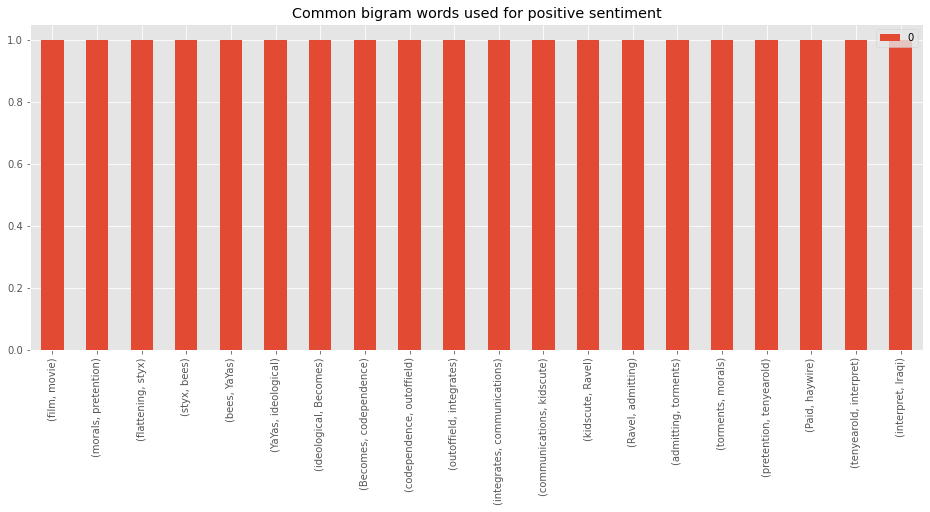

In [ ]:
# 시각화

pd.DataFrame(word_frequency,index = [0]).T.sort_values(by = [0],ascending = False).head(20).plot(
    kind = 'bar', figsize = (16,6), fontsize = 10, grid = True, title = 'Common bigram words used for positive sentiment')

# Part 2 Machine Learning Modeling

Prepare Training data



Create Bag of words with CountVectorizer (CountVectorizer를 사용하여 bog만들기)

In [ ]:
train['tokenized_words'] = train['Phrase'].apply(lambda x: word_tokenize(x))
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class,PhraseLength,tokenized_words
0,1,1,series escapades demonstrating adage good goos...,1,somewhat negative,108,"[series, escapades, demonstrating, adage, good..."
1,2,1,series escapades demonstrating adage good goose,2,neutral,47,"[series, escapades, demonstrating, adage, good..."
2,3,1,series,2,neutral,6,[series]
3,4,1,,2,neutral,0,[]
4,5,1,series,2,neutral,6,[series]


In [ ]:
count_vectorizer = CountVectorizer()
phrase_dtm = count_vectorizer.fit_transform(train['Phrase'])

In [ ]:
phrase_dtm.shape

(156060, 15746)

Split data into training and validation sets (70:30) ratio (학습 / 검증용 데이터 분리 - 7:3 비율)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(phrase_dtm, train['Sentiment'],
                                                  test_size = 0.3, random_state = 38)
X_train.shape,y_train.shape,X_val.shape,y_val.shape

((109242, 15746), (109242,), (46818, 15746), (46818,))

Train Logistic Regression model (로지스틱 회귀 모델 훈련)

In [ ]:
model=LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

Measure model performance (모델 성능 측정)

In [ ]:
accuracy_score(model.predict(X_val), y_val)*100

63.75752915545303

Free up memory for tf-idf (tf-idf에 대한 메모리 사용 가능)

In [ ]:
del X_train
del X_val
del y_train
del y_val

Preparing data with tf-idf (tf-idf를 사용하요 데이터 준비)

In [ ]:
tfidf = TfidfVectorizer()
fridf_dtm = tfidf.fit_transform(train['Phrase'])

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(fridf_dtm, train['Sentiment'],
                                                  test_size = 0.3, random_state = 38)
X_train.shape,y_train.shape,X_val.shape,y_val.shape

((109242, 15746), (109242,), (46818, 15746), (46818,))

In [ ]:
tfidf_model=LogisticRegression()
tfidf_model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
accuracy_score(tfidf_model.predict(X_val),y_val)*100

62.37985390234525

Predict on test data (검증용 데이터를 사용하여 예측)

In [ ]:
print(tfidf_model.predict(X_val)[0:10])

[3 2 2 2 2 2 2 3 2 3]


new data prediction function (새로운 데이터 예측 함수)

In [ ]:
def predict_new_text(text):
  tfidf_text = tfidf.transform([text])
  return tfidf_model.predict(tfidf_text)

In [ ]:
predict_new_text('The movie is bad and sucks!')

# 문구를 보면 매우 만족스럽지 못한 리뷰이다.
# 분류결과 0 : negative로 잘 분류되었다.

array([0])

Prepare Test Data

In [ ]:
test['Phrase']=test['Phrase'].apply(lambda x:remove_punctuation(x))
test['Phrase']=test['Phrase'].apply(lambda x:words_with_more_than_three_chars(x))
test['Phrase']=test['Phrase'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
test_dtm=tfidf.transform(test['Phrase'])

In [ ]:
# 테스트 데이터를 활용하여 예측
test['Sentiment']=tfidf_model.predict(test_dtm)
test.set_index=test['PhraseId']
test.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,156061,8545,intermittently pleasing mostly routine effort,3
1,156062,8545,intermittently pleasing mostly routine effort,3
2,156063,8545,,2
3,156064,8545,intermittently pleasing mostly routine effort,3
4,156065,8545,intermittently pleasing mostly routine,3
